## Energy module - basic functionality
In this notebook, we set up graph with a single edge to demonstrate some basic functionality of the Energy module.

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
from shapely.geometry import Point, LineString

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
from opentnsim import core as core_module
from opentnsim import energy as energy_module
from opentnsim import graph as graph_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _ConsumesEnergy_ - enables calculation of resistance, required power and emissions

In [2]:
#We create a type element that schematisizes a vessel
def create_vessel(env,
                  name,
                  origin, 
                  destination, 
                  vessel_type, 
                  L, 
                  B, 
                  T,
                  v,
                  P_tot_given, 
                  arrival_time):
    
    Vessel = type('Vessel',(energy_module.ConsumesEnergy,   # The vessel consumes energy
                            vessel_module.IsVessel,         # Basic information of the vessel
                           ),{})  
    
    vessel = Vessel(**{ "env": env,
                        "name": name,
                        "origin": origin,
                        "destination": destination,
                        "type": vessel_type,
                        "L": L,                     # m
                        "B": B,                     # m
                        "T": T,                     # m
                        "v": v,                     # m/s None: calculate this value based on P_tot_given
                        "safety_margin": 0.2,       # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                        "h_squat": False,           # if consider the ship squatting while moving, set to True, otherwise set to False
                        "P_installed": 1750.0,      # kW
                        "P_tot_given": P_tot_given, # kW None: calculate this value based on speed
                        "bulbous_bow": False,       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                        "P_hotel_perc": 0.05,
                        "P_hotel": None,            # None: calculate P_hotel from percentage
                        "x": 2,                     # number of propellers
                        "L_w": 3.0 ,
                        "C_B": 0.85,                # block coefficient 
                        "C_year": 1990,             # engine build year
                        "arrival_time": arrival_time,
                      }
                   )

    env.process(vessel.move())
    
    return vessel

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

In [3]:
FG = nx.DiGraph()

# specifiy nodes and edges
node_A = graph_module.Node(name='0',geometry=Point(0,0))
node_B = graph_module.Node(name='1',geometry=Point(0.8983,0))

edges = [(node_A,node_B)]

# create a graph object
depths = {"GeneralDepth": [6.0]}
FG = graph_module.DiGraph(edges=edges,edges_info=depths).graph

In [4]:
# collect node positions and labels
nodes = []
coordinates = []
labels = {}

for node in FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(FG, 'geometry')[node].x, nx.get_node_attributes(FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

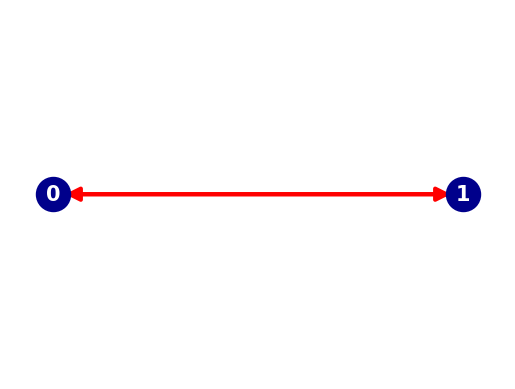

In [5]:
# draw edges, nodes and labels
nx.draw_networkx_edges(FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG, pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

In [6]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('0', '1') is 6.0 m
General depth for edge ('1', '0') is 6.0 m


### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [7]:
def create_run(FG,
               name,
               origin, 
               destination, 
               vessel_type, 
               L, 
               B, 
               T,
               v,
               P_tot_given, 
               arrival_time):
    
    # Start simpy environment
    t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)
    
    env = simpy.Environment(initial_time=t_start.timestamp())
    
    env.epoch = t_start
    env.simulation_start = t_start
    
    # Add graph to environment
    env.FG = FG
    
    #In order from ships to know where they are going we need to add an VTS to the environment
    env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

    # Create vessel
    vessel = create_vessel(env=env,
                           name='Vessel',
                           origin='0', 
                           destination='1', 
                           vessel_type='inland vessel', 
                           L=L,                         # m
                           B=B,                         # m 
                           T=T,                         # m
                           v=v,                         # m/s
                           P_tot_given=P_tot_given,     # kW 
                           arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))
    
    env.run()
    
    energycalculation = opentnsim.energy.EnergyCalculation(env.FG, vessel)
    energycalculation.calculate_energy_consumption()
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    df['fuel_kg_per_km'] = (df['total_diesel_consumption_ICE_mass'] / 1000) / (df['distance']/1000)
    df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
    df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
    df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
    return df

### 4.1 Show the effects of vessel velocity
We will now sail the same path with the same vessel at different speeds

In [8]:
v_list = list(np.arange(1,4,.1))

dfs = []
for v in v_list:
    print('v = {}'.format(v))
    dfs.append(create_run(FG=FG,
                          name='Vessel',
                          origin='0', 
                          destination='1', 
                          vessel_type='inland vessel', 
                          L=110,                # m
                          B=11.4,               # m 
                          T=3.5,                # m
                          v=v,                  # m/s
                          P_tot_given=None,     # kW 
                          arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0)))

v = 1.0
v = 1.1
v = 1.2000000000000002
v = 1.3000000000000003
v = 1.4000000000000004
v = 1.5000000000000004
v = 1.6000000000000005
v = 1.7000000000000006
v = 1.8000000000000007
v = 1.9000000000000008
v = 2.000000000000001
v = 2.100000000000001
v = 2.200000000000001
v = 2.300000000000001
v = 2.4000000000000012
v = 2.5000000000000013
v = 2.6000000000000014
v = 2.7000000000000015
v = 2.8000000000000016
v = 2.9000000000000017
v = 3.0000000000000018
v = 3.100000000000002
v = 3.200000000000002
v = 3.300000000000002
v = 3.400000000000002
v = 3.500000000000002
v = 3.6000000000000023
v = 3.7000000000000024
v = 3.8000000000000025
v = 3.9000000000000026


In [9]:
total_energy=[]
for index, df in enumerate(dfs):
    total_energy.append(df.total_energy.values[0])
    print('At {:.1f} m/s the vessel uses {:.2f} kW for {:.2f} mins = {:.2f} kWh '.format(v_list[index], df.P_given.values[0],df.delta_t.values[0]/60,df.total_energy.values[0]))

At 1.0 m/s the vessel uses 98.95 kW for 1666.64 mins = 2748.53 kWh 
At 1.1 m/s the vessel uses 102.56 kW for 1515.13 mins = 2589.95 kWh 
At 1.2 m/s the vessel uses 106.85 kW for 1388.87 mins = 2473.37 kWh 
At 1.3 m/s the vessel uses 111.86 kW for 1282.03 mins = 2390.21 kWh 
At 1.4 m/s the vessel uses 117.65 kW for 1190.46 mins = 2334.35 kWh 
At 1.5 m/s the vessel uses 124.27 kW for 1111.09 mins = 2301.26 kWh 
At 1.6 m/s the vessel uses 131.77 kW for 1041.65 mins = 2287.56 kWh 
At 1.7 m/s the vessel uses 140.19 kW for 980.38 mins = 2290.62 kWh 
At 1.8 m/s the vessel uses 149.59 kW for 925.91 mins = 2308.42 kWh 
At 1.9 m/s the vessel uses 160.01 kW for 877.18 mins = 2339.34 kWh 
At 2.0 m/s the vessel uses 171.51 kW for 833.32 mins = 2382.06 kWh 
At 2.1 m/s the vessel uses 184.13 kW for 793.64 mins = 2435.55 kWh 
At 2.2 m/s the vessel uses 197.59 kW for 757.56 mins = 2494.72 kWh 
At 2.3 m/s the vessel uses 212.54 kW for 724.63 mins = 2566.92 kWh 
At 2.4 m/s the vessel uses 221.10 kW for 6

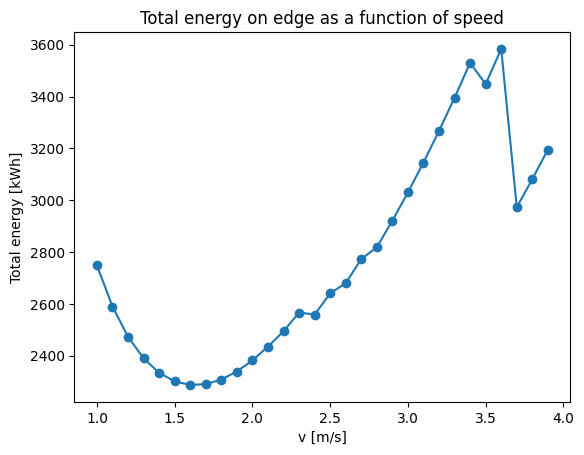

In [10]:
fig, axes = plt.subplots(1,1)

plt.plot(v_list, total_energy, 'o-')

axes.set_xlabel('v [m/s]');
axes.set_ylabel('Total energy [kWh]');
axes.set_title('Total energy on edge as a function of speed');